In [12]:
import random
import csv
from random import randint
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt

In [13]:
series_id_list = [
    "Spänning L1",
    "Spänning L2",
    "Spänning L3",
    "P14 L1",
    "P14 L2",
    "P14 L3",
    "P23 L1",
    "P23 L2",
    "P23 L3",
    "A14",
    "A23",
    "Q12 L1",
    "Q12 L2",
    "Q12 L3",
    "Q34 L1",
    "Q34 L2",
    "Q34 L3",
    "R12",
    "R34",
]
fieldnames = [
    "series_id",
    "location_id",
    "meter_id",
    "time",
    "value",
    "value_status",
    "insert_time",
    "extract_time",
]

In [14]:
# [(location id,meter id)]
unique_lid_mid = [
    (
        "".join(["{}".format(random.randint(0, 9)) for _ in range(18)]),
        "".join(["{}".format(random.randint(0, 9)) for _ in range(16)]),
    )
    for _ in range(10)
]

In [15]:
def get_value(sid, is_high, is_low):
    if sid.startswith("Spänning"):
        if is_high:
            return round(random.uniform(241, 246), 0)
        elif is_low:
            return round(random.uniform(229, 234), 0)
        else:
            return round(random.uniform(235, 240), 0)
    elif sid.startswith("P14"):  # active-power-consumption/kW
        if is_high:
            return round(random.uniform(2, 3), 3)
        elif is_low:
            return round(random.uniform(0.01, 1), 3)
        else:
            return round(random.uniform(1, 2), 3)
    elif sid.startswith("P23"):  # active-power-production/kW
        if is_high:
            return round(random.uniform(2, 3), 3)
        elif is_low:
            return round(random.uniform(0.01, 1), 3)
        else:
            return round(random.uniform(1, 2), 3)
    elif sid.startswith("A14"):  # active-energy-consumption/kWh
        if is_high:
            return round(random.uniform(240, 245), 2)
        elif is_low:
            return round(random.uniform(230, 235), 2)
        else:
            return round(random.uniform(235, 240), 2)
    elif sid.startswith("A23"):  # active-energy-production/kWh
        if is_high:
            return round(random.uniform(240, 245), 2)
        elif is_low:
            return round(random.uniform(230, 235), 2)
        else:
            return round(random.uniform(235, 240), 2)
    elif sid.startswith("Q12"):  # reactive-power-consumption/kVAr
        if is_high:
            return round(random.uniform(240, 245), 2)
        elif is_low:
            return round(random.uniform(230, 235), 2)
        else:
            return round(random.uniform(235, 240), 2)
    elif sid.startswith("Q34"):  # reactive-power-production/kVAr
        if is_high:
            return round(random.uniform(240, 245), 2)
        elif is_low:
            return round(random.uniform(230, 235), 2)
        else:
            return round(random.uniform(235, 240), 2)
    elif sid.startswith("R12"):  # reactive-energy-consumption/kVArh
        if is_high:
            return round(random.uniform(240, 245), 2)
        elif is_low:
            return round(random.uniform(230, 235), 2)
        else:
            return round(random.uniform(235, 240), 2)
    elif sid.startswith("R34"):  # reactive-energy-production/kVArh
        if is_high:
            return round(random.uniform(240, 245), 2)
        elif is_low:
            return round(random.uniform(230, 235), 2)
        else:
            return round(random.uniform(235, 240), 2)

In [16]:
def generate_event(time, is_high, is_low):
    for lid, mid in unique_lid_mid:
        for x in series_id_list:

            yield {
                "series_id": x,
                "location_id": lid,
                "meter_id": mid,
                "time": time,
                "value": get_value(x, is_high, is_low),
                "value_status": "Correct",
                "insert_time": time,
                "extract_time": time,
            }

In [17]:
# total iteration that will run
# in total 19 * 10 * total_event (19 series id, 10 meter-location ids)
total_event = 10000

# start deviation after 100 iteration
deviation_start = 1000
# there will be deviation_time times a deviation will occur
deviation_time = 10
# the deviation duration in iteration
deviation_duration_count = 500
# offset so that two deviation iteration are not side by side
offset = 0

possible_values = list(
    range(
        deviation_start,
        total_event - deviation_duration_count,
        deviation_duration_count + offset,
    )
)
print(possible_values)
# deviation iteration value on when to trigger a deviation
deviation_points = sorted(random.sample(possible_values, deviation_time))
print(deviation_points)

[1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500, 7000, 7500, 8000, 8500, 9000]
[1000, 1500, 2000, 3500, 4500, 5000, 6000, 6500, 7500, 9000]


In [18]:
# file
file_path = "data/generated_event.csv"

In [19]:
def generate_readings(start_time, total_event):
    current_time = start_time

    with open(file_path, mode="w", newline="", encoding="utf8") as file:
        writer = csv.DictWriter(file, fieldnames=fieldnames)
        writer.writeheader()
        dev_count = 0
        is_high = False
        is_low = False

        for itr in range(total_event):

            if itr in deviation_points:
                if random.choice((True, False)):
                    is_high = True
                else:
                    is_low = True

            if not is_low and not is_high:
                event_gen = generate_event(
                    current_time.timestamp() * 1000, False, False
                )

            if is_low:
                event_gen = generate_event(current_time.timestamp() * 1000, False, True)
                dev_count += 1
                if dev_count == deviation_duration_count:
                    is_low = False
                    dev_count = 0

            if is_high:
                event_gen = generate_event(current_time.timestamp() * 1000, True, False)
                dev_count += 1
                if dev_count == deviation_duration_count:
                    is_high = False
                    dev_count = 0

            for _ in range((len(series_id_list) * len(unique_lid_mid))):
                event = next(event_gen)
                writer.writerow(event)

            current_time += timedelta(minutes=15)

In [20]:
# User-defined start time
start_time_str = "2024-01-15 08:00:00"
start_time = datetime.strptime(start_time_str, "%Y-%m-%d %H:%M:%S")

# Generate readings
generate_readings(start_time, total_event)

In [21]:
# filter
selected_series_id = "Spänning L1"

In [22]:
def plot(selected_series_id, selected_location_id):
    chunk_size = 10000
    time_data, value_data = [], []

    # with milliseconds
    # .strftime('%Y-%m-%d %H:%M:%S.%f')[:-3]

    dateparse = lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S.%f")
    # , parse_dates=["time"], date_parser=dateparse

    for chunk in pd.read_csv(file_path, chunksize=chunk_size):
        filtered_chunk = chunk[
            (selected_series_id == chunk["series_id"])
            & (selected_location_id == chunk["location_id"])
        ]

        time_data.extend(filtered_chunk["time"])
        value_data.extend(filtered_chunk["value"])

    # Plot the data
    plt.figure(figsize=(12, 6))
    plt.plot(
        time_data,
        value_data,
        marker="o",
        linestyle="-",
        markersize=3,
        color="b",
        alpha=0.7,
    )

    # Formatting the plot
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.title(
        f"Plot of 'Value' Over 'Time' (Series ID: {selected_series_id}, Location ID: {selected_location_id})"
    )
    plt.xticks(rotation=45)
    plt.grid()
    plt.show()

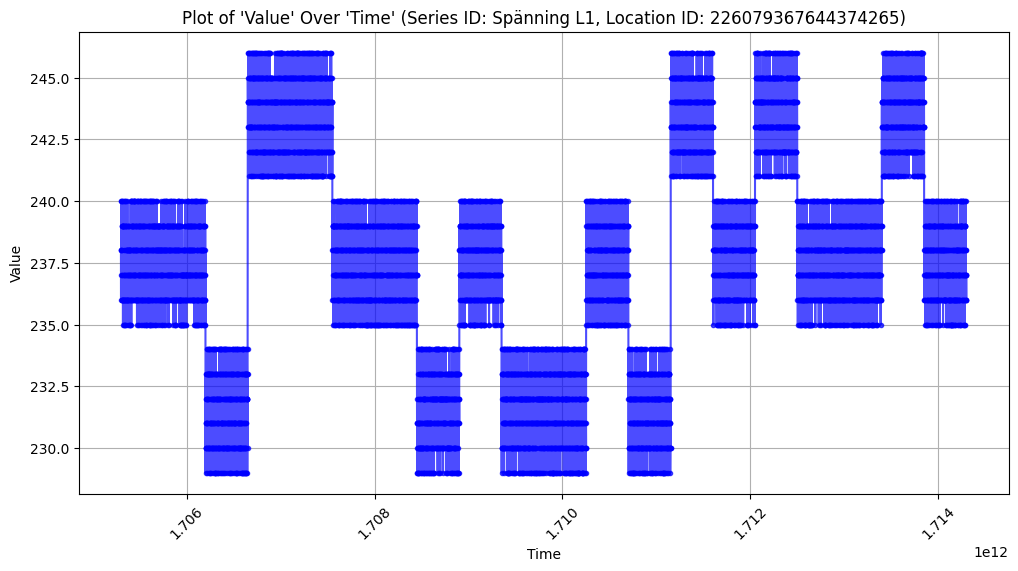

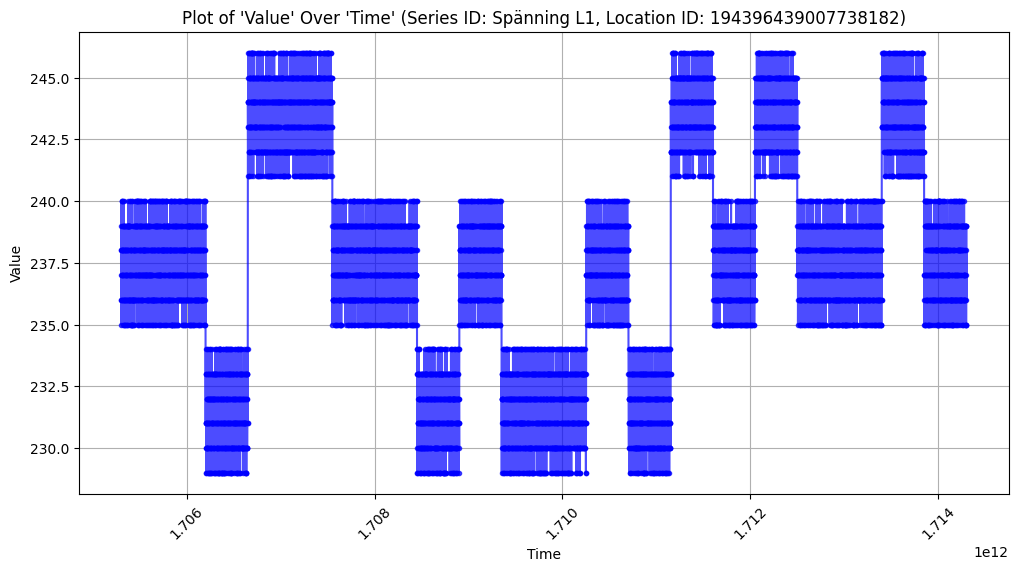

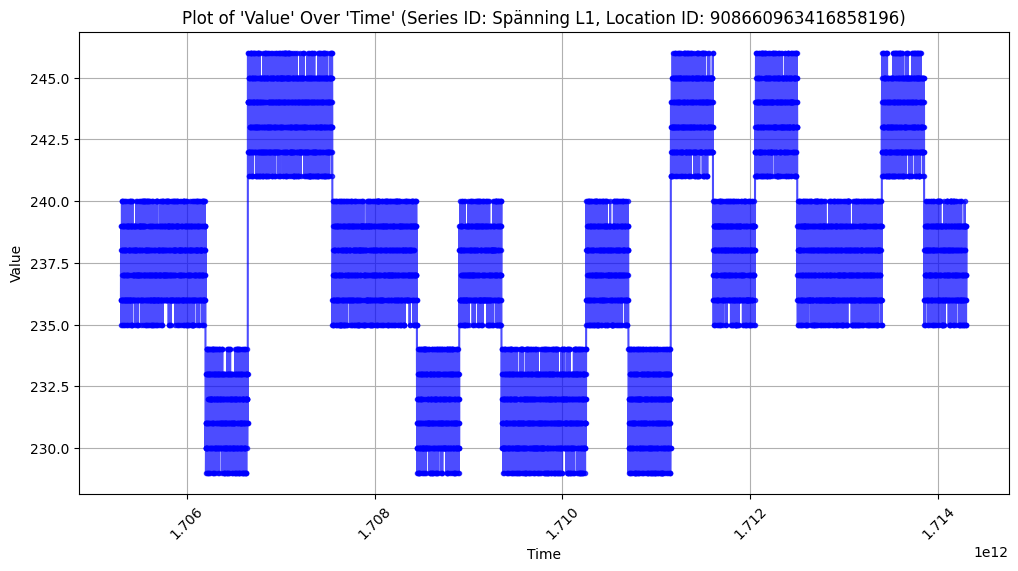

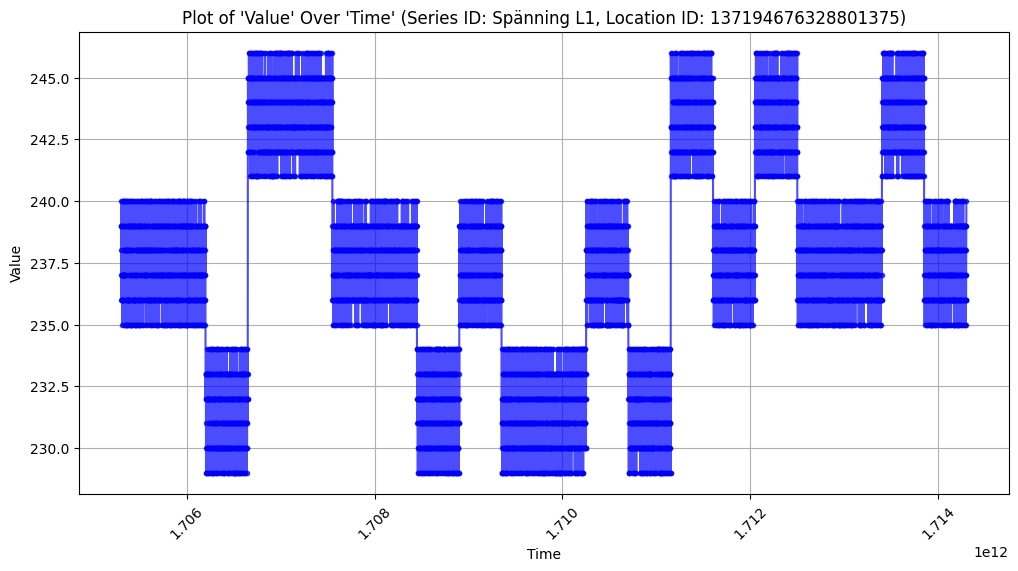

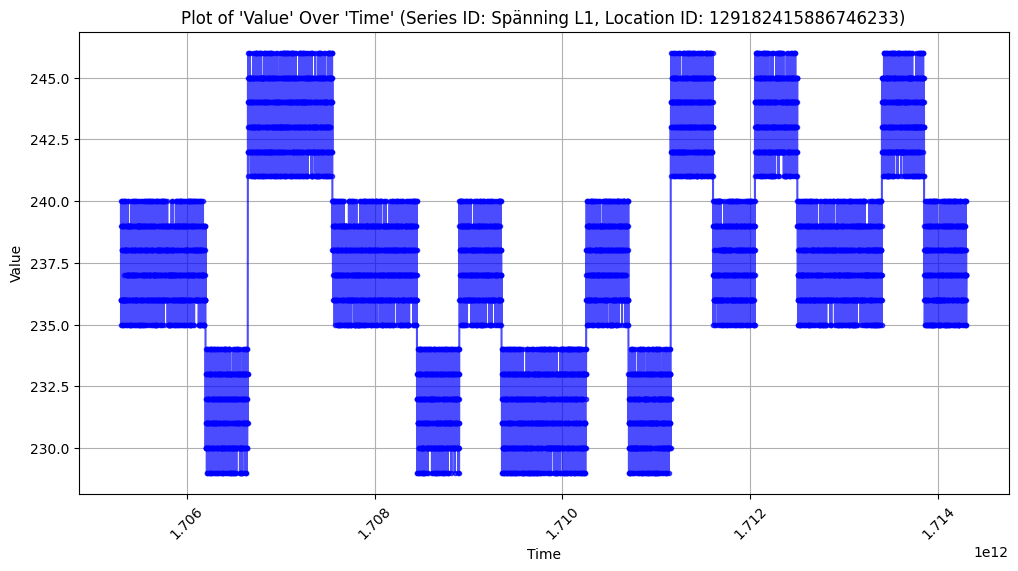

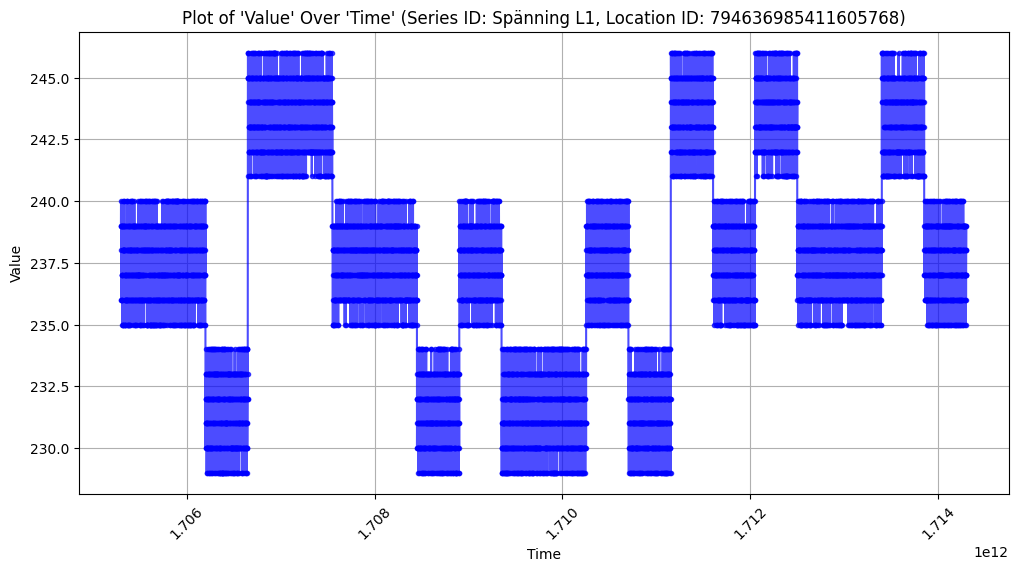

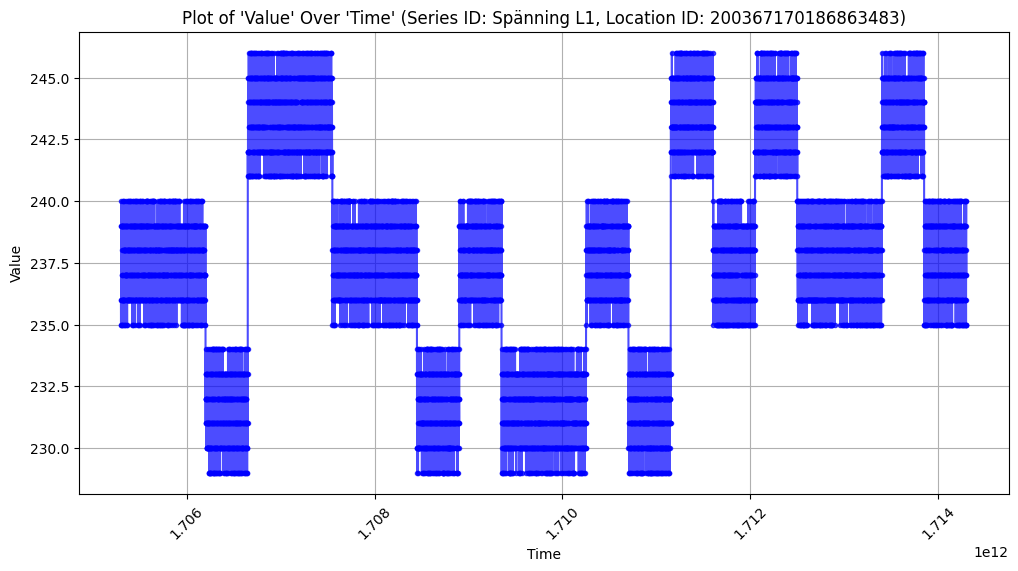

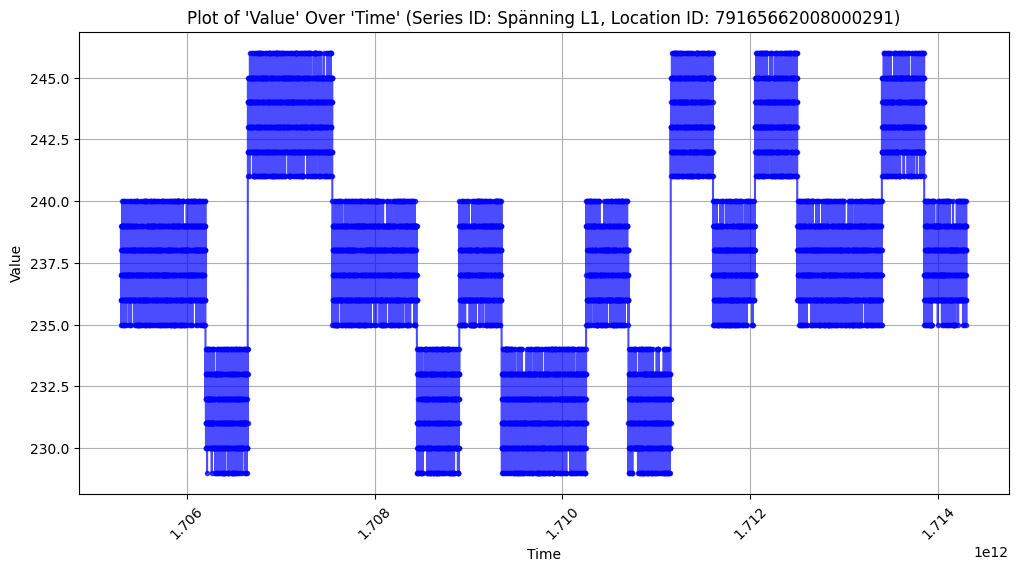

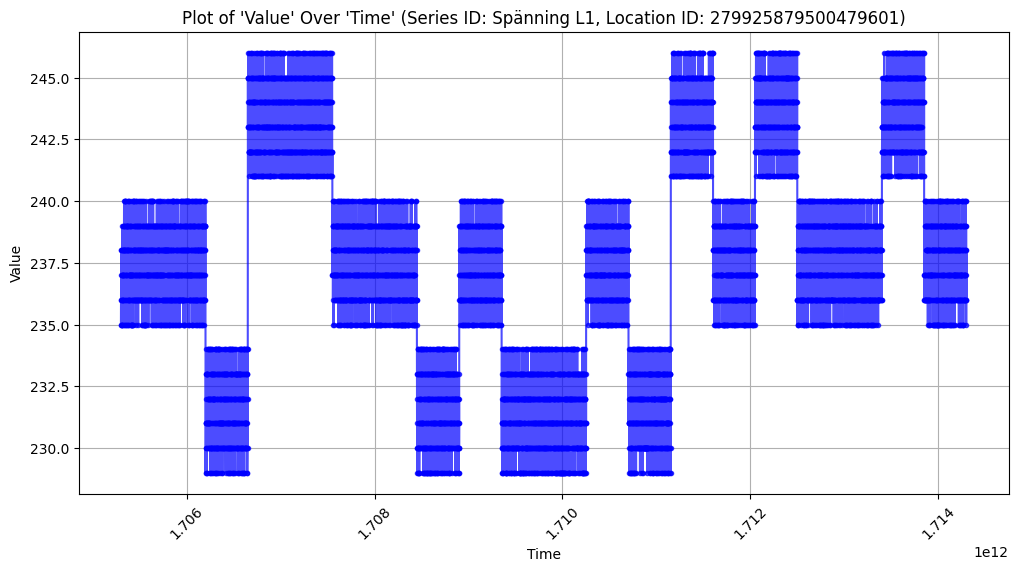

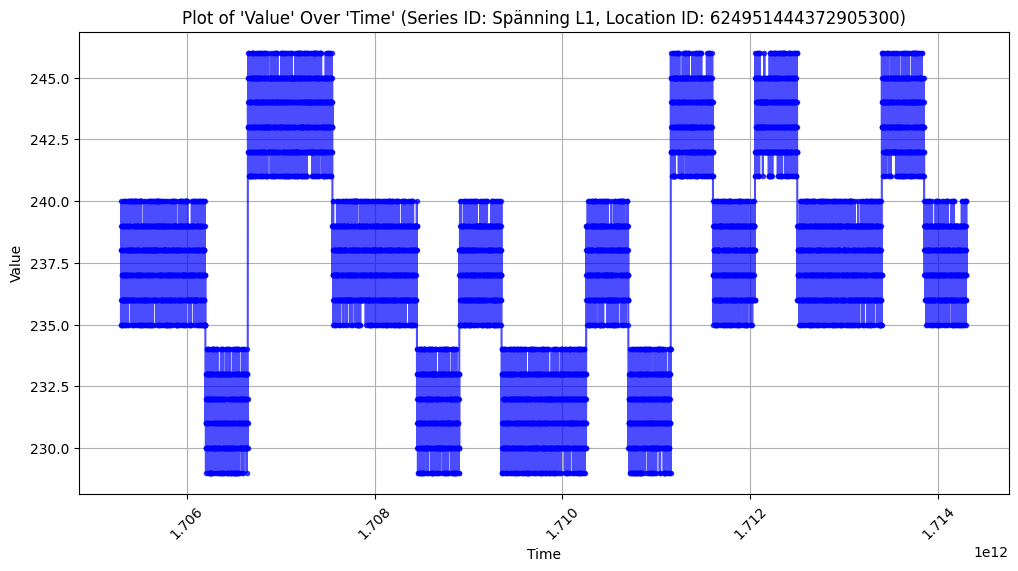

In [23]:
for loc, met in unique_lid_mid:
    plot(selected_series_id, int(loc))

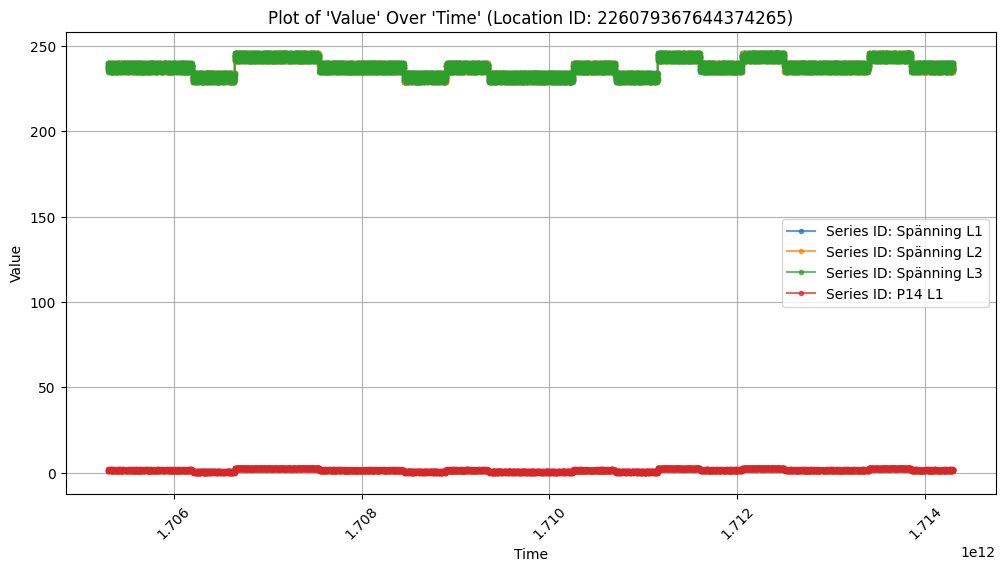

In [28]:
def plot(selected_series_ids, selected_location_id, file_path):
    chunk_size = 10000
    time_series_data = {}

    # Initialize storage for each series ID
    for series_id in selected_series_ids:
        time_series_data[series_id] = {"time": [], "value": []}

    # Read CSV in chunks
    for chunk in pd.read_csv(file_path, chunksize=chunk_size):
        filtered_chunk = chunk[chunk["location_id"] == selected_location_id]

        for series_id in selected_series_ids:
            series_data = filtered_chunk[filtered_chunk["series_id"] == series_id]
            time_series_data[series_id]["time"].extend(series_data["time"])
            time_series_data[series_id]["value"].extend(series_data["value"])

    # Plot the data
    plt.figure(figsize=(12, 6))

    for series_id, data in time_series_data.items():
        plt.plot(
            data["time"],
            data["value"],
            marker="o",
            linestyle="-",
            markersize=3,
            alpha=0.7,
            label=f"Series ID: {series_id}",
        )

    # Formatting the plot
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.title(f"Plot of 'Value' Over 'Time' (Location ID: {selected_location_id})")
    plt.xticks(rotation=45)
    plt.grid()
    plt.legend()
    plt.show()


# Example usage
selected_series_ids = ["Spänning L1", "Spänning L2", "Spänning L3", "P14 L1"]
target_location_id = 226079367644374265  # Replace with actual location ID
file_path = "data/generated_event.csv"  # Replace with the actual file path
plot(selected_series_ids, target_location_id, file_path)

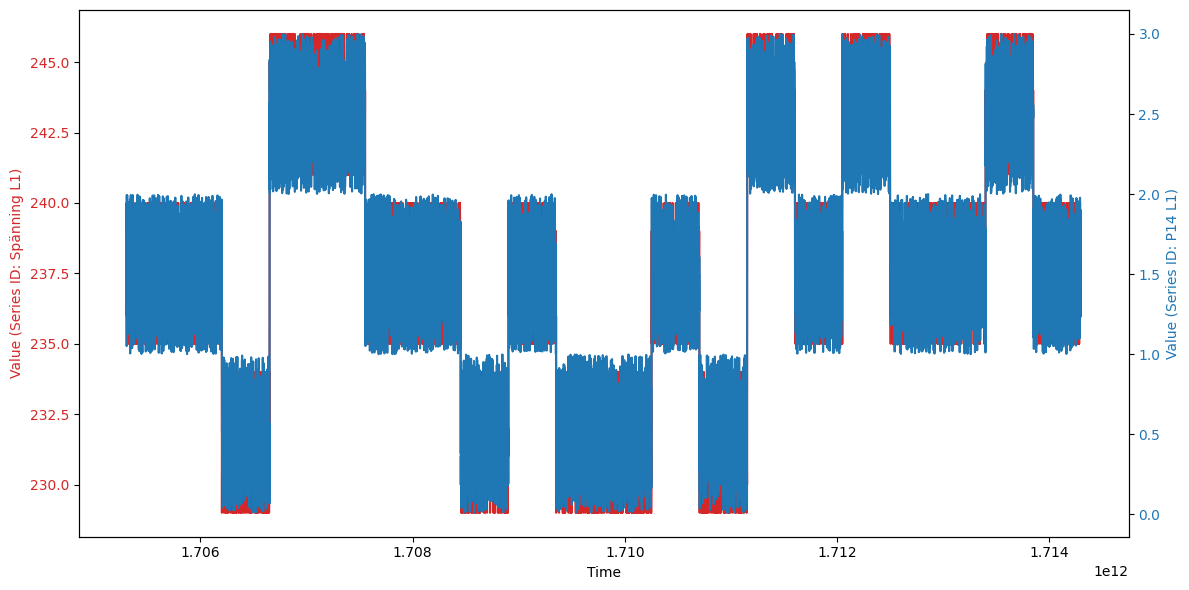

In [36]:
def plot_dual_axis(selected_series_ids, selected_location_id, file_path):
    chunk_size = 10000
    time_series_data = {}

    # Initialize storage for each series ID
    for series_id in selected_series_ids:
        time_series_data[series_id] = {"time": [], "value": []}

    # Read CSV in chunks
    for chunk in pd.read_csv(file_path, chunksize=chunk_size):
        filtered_chunk = chunk[chunk["location_id"] == selected_location_id]

        for series_id in selected_series_ids:
            series_data = filtered_chunk[filtered_chunk["series_id"] == series_id]
            time_series_data[series_id]["time"].extend(series_data["time"])
            time_series_data[series_id]["value"].extend(series_data["value"])

    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plot first series on primary y-axis
    first_series_id = selected_series_ids[0]
    color = "tab:red"
    ax1.set_xlabel("Time")
    ax1.set_ylabel(f"Value (Series ID: {first_series_id})", color=color)
    ax1.plot(
        time_series_data[first_series_id]["time"],
        time_series_data[first_series_id]["value"],
        color=color,
    )
    ax1.tick_params(axis="y", labelcolor=color)

    # Create secondary y-axis
    ax2 = ax1.twinx()

    if len(selected_series_ids) > 1:
        second_series_id = selected_series_ids[3]
        color = "tab:blue"
        ax2.set_ylabel(f"Value (Series ID: {second_series_id})", color=color)
        ax2.plot(
            time_series_data[second_series_id]["time"],
            time_series_data[second_series_id]["value"],
            color=color,
        )
        ax2.tick_params(axis="y", labelcolor=color)

    fig.tight_layout()
    plt.show()


# Example usage
selected_series_ids = ["Spänning L1", "Spänning L2", "Spänning L3", "P14 L1"]
target_location_id = 226079367644374265  # Replace with actual location ID
file_path = "data/generated_event.csv"  # Replace with the actual file path
plot_dual_axis(selected_series_ids, target_location_id, file_path)